In [1]:
import copy
import time
from tqdm.notebook import tqdm
from collections import namedtuple

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
import SimpleITK as sitk
from PIL import Image
from imageio import imread
%matplotlib inline
from PIL import Image
from imageio import imread
from joblib import Parallel, delayed
from collections import namedtuple
from skimage.feature import hog

In [3]:
df = pd.read_csv('/kaggle/input/dataset445/Dataset.csv')

In [4]:
df

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1
...,...,...,...,...,...
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.272259794130...,56.590000,46.410000,-131.960000,0
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904...,-40.960000,34.950000,-78.090000,0
441,1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664...,-45.650000,17.150000,-93.290000,0
442,1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654...,60.608303,-5.163615,-255.692349,0


In [5]:
df = df.reset_index(drop=True)

In [6]:
from skimage.feature import graycomatrix, graycoprops

In [7]:
df

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1
...,...,...,...,...,...
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.272259794130...,56.590000,46.410000,-131.960000,0
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904...,-40.960000,34.950000,-78.090000,0
441,1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664...,-45.650000,17.150000,-93.290000,0
442,1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654...,60.608303,-5.163615,-255.692349,0


In [8]:
df['ImageGabor'] =''
df['Hu1'] = ''
df['Hu2'] = ''
df['Hu3'] = ''
df['Hu4'] = ''
df['Hu5'] = ''
df['Hu6'] = ''
df['Hu7'] = ''

# Gabor filter fonctions

In [9]:
def Gabor_filter(K_size=111, Sigma=7, Gamma=0.5, Lambda=np.pi, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


# Use Gabor filter to act on the image
def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


# Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
#     print(img.shape)
    # get shape
    H, W = img.shape

    # gray scale
    # gray = BGR2GRAY(img).astype(np.float32)

    # define angle
    #As = [0, 45, 90, 135]
    As = [0,30,60,90,120,150]

    # prepare pyplot
#     plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([H, W], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
    
        # gabor filtering
        _out = Gabor_filtering(img, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)
         

        # add gabor filtered image
        out += _out
        

    # scale normalization
    out = out /out.max()*255
    out = out.astype(np.uint8)

    return out

# **HU MOMENTS SUR UNE 2D**

In [10]:
#2 fonctions que j'appelle pour la normalisation 
def copysign(x, y):
    """Return x with the sign of y."""
    return np.copysign(x, y)

def log10(x):
    """Return the base-10 logarithm of x."""
    return np.log10(x)

In [11]:
import cv2
from math import copysign, log10

def calculerHu(img):
    # seuiller l'image si <128 alors 0 si > alors 255 
    _,img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    
    # Calculer les moments de l'image
    moments = cv2.moments(img) 
    
    # Calculer les moments de Hu de l'image
    huMoments = cv2.HuMoments(moments)

    # Mise à l'échelle logarithmique des moments de Hu, normalisation et rendant les valeurs indépendantes de la rotation et de l'échelle
    for i in range(0, 7): 
        # moment_value = huMoments[i][0] if isinstance(huMoments[i], np.ndarray) else huMoments[i] // ligne au cas ou erreur
        huMoments[i] = (-1 * copysign(1.0, huMoments[i]) * log10(abs(huMoments[i] + 1e-10)))
    
    return huMoments

# Semi Segmentation and gabor filter application

In [12]:
j=0

for _, i in df.iterrows():
    print(j)
    file_path = glob.glob(f'/kaggle/input/luna16/subset*/*/{i.seriesuid}.mhd')
    mhd_file = sitk.ReadImage(file_path[0])
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    ct_scan.clip(-1000, 1000, ct_scan)
    
    origin_xyz = mhd_file.GetOrigin()
    voxel_size_xyz = mhd_file.GetSpacing()
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
    origin_xyz_np = np.array(origin_xyz)
    voxel_size_xyz_np = np.array(voxel_size_xyz)

    center_xyz = (i.coordX,i.coordY,i.coordZ)
    cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

# Since we'll be using column, row and index values to index into arrays,
# we round them to the nearest integer.
    cri = np.round(cri)

# Going forward, we'll need the scan to be in the order index, row, column
    irc = (int(cri[2]), int(cri[1]), int(cri[0]))
    
    dims_irc = (10, 18, 18)
    
    slice_list = []

    for axis, center_val in enumerate(irc):
    
    # Get start and end index for the dimension so that the
    # nodule center is at the center of the 3d array we extract
        start_index = int(round(center_val - dims_irc[axis]/2))
        end_index = int(start_index + dims_irc[axis])

    # Adjust the indexes if the start_index is out of the CT scan array
        if start_index < 0:
            start_index = 0
            end_index = int(dims_irc[axis])
    
        # Do the same check for the end_index
        if end_index > ct_scan.shape[axis]:
            end_index = ct_scan.shape[axis]
            start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
        slice_list.append(slice(start_index, end_index))
    
    tuple(slice_list)
    ct_scan_chunk = ct_scan[tuple(slice_list)]
    ct_scan_chunk.shape
    ctt = np.array(ct_scan_chunk).astype(int)
    max = np.max(ctt)
    min_val = np.min(ctt)
    max_val = np.max(ctt)

    # Normaliser le tableau à la plage [0, 255]
    nctt = (ctt - min_val) * (255 / (max_val - min_val))

    # Convertir le tableau en type entier
    nctt = nctt.astype(np.uint8)
    Gabor_image_3d = np.zeros((10, 18, 18))
    Hu_sum = np.zeros(7)
    for z in range(nctt.shape[0]):
        image = Gabor_process(nctt[z,:,:])
        Gabor_image_3d[z,:,:] += image
        features = calculerHu(image)
        Hu_sum += features[:,0]
    
    Hu_mean = Hu_sum / nctt.shape[0]
    
    df.at[j,'ImageGabor'] = Gabor_image_3d
    df.at[j, 'Hu1'] = Hu_mean[0]
    df.at[j, 'Hu2'] = Hu_mean[1]
    df.at[j, 'Hu3'] = Hu_mean[2]
    df.at[j, 'Hu4'] = Hu_mean[3]
    df.at[j, 'Hu5'] = Hu_mean[4]
    df.at[j, 'Hu6'] = Hu_mean[5]
    df.at[j, 'Hu7'] = Hu_mean[6]
    
    j=j+1
    


0


/tmp/ipykernel_34/4193525352.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  huMoments[i] = (-1 * copysign(1.0, huMoments[i]) * log10(abs(huMoments[i] + 1e-10)))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


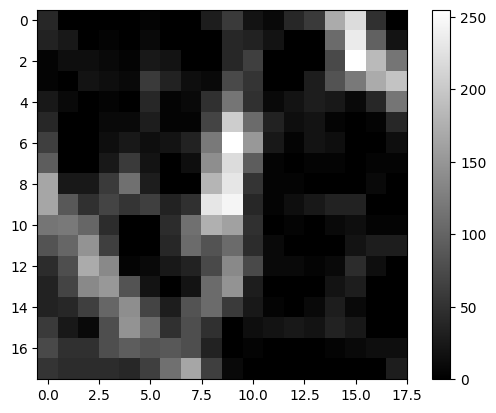

In [13]:
plt.imshow(Gabor_image_3d[5,:,:], cmap='gray')
plt.colorbar()  # Ajouter une barre de couleur
plt.show()

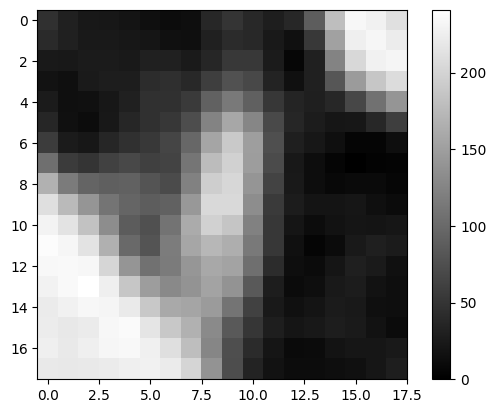

In [14]:
plt.imshow(nctt[5,:,:], cmap='gray')
plt.colorbar()  # Ajouter une barre de couleur
plt.show()

# **Train the model**

In [15]:
df

,seriesuid,coordX,coordY,coordZ,class,ImageGabor,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1,"[[[0.0, 13.0, 6.0, 27.0, 27.0, 13.0, 0.0, 0.0,...",2.359248,4.993708,8.014268,8.765702,-4.0,-0.030451,-4.0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1,"[[[0.0, 6.0, 6.0, 26.0, 26.0, 0.0, 0.0, 20.0, ...",2.402821,5.062661,8.013885,8.3312,9.919146,9.562074,-0.042756
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1,"[[[10.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 10.0, 0...",2.455086,5.55252,8.12536,8.430049,5.999991,5.867233,1.999999
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1,"[[[78.0, 65.0, 19.0, 19.0, 13.0, 13.0, 13.0, 0...",3.138177,5.843027,7.650039,8.126684,3.999926,5.695506,-4.000044
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1,"[[[0.0, 0.0, 0.0, 4.0, 0.0, 8.0, 17.0, 22.0, 1...",2.309242,5.779389,7.753804,7.989094,3.999993,5.861574,-2.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.272259794130...,56.590000,46.410000,-131.960000,0,"[[[6.0, 12.0, 31.0, 28.0, 9.0, 9.0, 22.0, 19.0...",2.280205,5.249927,7.237799,7.655497,7.999879,5.640402,1.999991
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.253283426904...,-40.960000,34.950000,-78.090000,0,"[[[46.0, 0.0, 3.0, 32.0, 43.0, 0.0, 0.0, 10.0,...",2.159944,4.781973,6.882246,7.094673,5.989556,6.812982,-0.004085
441,1.3.6.1.4.1.14519.5.2.1.6279.6001.186021279664...,-45.650000,17.150000,-93.290000,0,"[[[8.0, 13.0, 2.0, 24.0, 0.0, 10.0, 52.0, 0.0,...",1.949597,4.084922,6.251742,6.514065,9.940337,8.26993,3.999111
442,1.3.6.1.4.1.14519.5.2.1.6279.6001.203741923654...,60.608303,-5.163615,-255.692349,0,"[[[0.0, 31.0, 63.0, 0.0, 63.0, 127.0, 95.0, 31...",2.469762,5.703143,8.45006,8.914284,5.999998,1.970069,-2.000001


In [16]:
X = df
y = df['class']

In [17]:
X = X.drop(['class','seriesuid','coordX','coordY','coordZ','ImageGabor'], axis=1)

In [18]:
X

,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7
0,2.359248,4.993708,8.014268,8.765702,-4.0,-0.030451,-4.0
1,2.402821,5.062661,8.013885,8.3312,9.919146,9.562074,-0.042756
2,2.455086,5.55252,8.12536,8.430049,5.999991,5.867233,1.999999
3,3.138177,5.843027,7.650039,8.126684,3.999926,5.695506,-4.000044
4,2.309242,5.779389,7.753804,7.989094,3.999993,5.861574,-2.000007
...,...,...,...,...,...,...,...
439,2.280205,5.249927,7.237799,7.655497,7.999879,5.640402,1.999991
440,2.159944,4.781973,6.882246,7.094673,5.989556,6.812982,-0.004085
441,1.949597,4.084922,6.251742,6.514065,9.940337,8.26993,3.999111
442,2.469762,5.703143,8.45006,8.914284,5.999998,1.970069,-2.000001


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train , X_test, Y_train , Y_test = train_test_split(X,y,test_size=0.2 ,random_state=42)

In [21]:
import pandas as pd

In [22]:
X_train

,Hu1,Hu2,Hu3,Hu4,Hu5,Hu6,Hu7
17,2.47893,5.20267,8.361885,8.457472,7.999932,3.963504,-0.000022
66,2.731879,6.135878,8.395326,8.528558,5.987622,3.218599,-2.000058
248,2.367843,4.795787,8.80786,8.887199,8.0,7.947811,-0.000001
246,2.333288,5.486487,7.63874,7.93823,3.98399,5.475,-0.001634
31,2.933776,6.220871,9.115745,9.457616,-0.000028,-0.159158,2.0
...,...,...,...,...,...,...,...
106,2.320945,5.320355,8.094405,8.860082,-6.0,-4.023313,2.0
270,2.162651,5.24742,7.085475,7.081874,3.994606,9.348123,-2.000597
348,2.075983,5.19053,6.731631,7.239182,1.999298,7.699803,1.990445
435,2.335372,5.157525,7.392331,7.600781,7.999401,7.349689,-0.000035


In [23]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [24]:
from sklearn.neighbors import KNeighborsClassifier


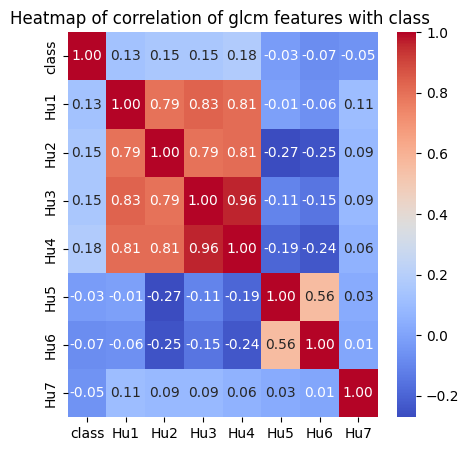

In [25]:
data= df
data= data.drop(['seriesuid','coordX','coordY','coordZ', 'ImageGabor'], axis=1)


# Créez la heatmap
plt.figure(figsize=(5, 5) ) 
heatmap = sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of correlation of glcm features with class ")

# Affichez la heatmap
plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier = KNeighborsClassifier(n_neighbors=9,algorithm='brute')
classifier.fit(X_scaled, Y_train)
test_accuracy = classifier.score(scaler.transform(X_test), Y_test)
print(test_accuracy)


0.7078651685393258


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Assuming you have already trained your model and obtained predictions
predictions = classifier.predict(scaler.transform(X_test))

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

# Print the results
print("Précision (Precision):", precision)
print("Sensibilité (Recall):", recall)
print("Score F1 (F1 score):", f1)

Précision (Precision): 0.7125
Sensibilité (Recall): 0.9344262295081968
Score F1 (F1 score): 0.8085106382978724


In [29]:
from joblib import dump
dump(classifier, 'knn_Gabor.joblib')

['knn_Gabor.joblib']

In [30]:

best_C = None
best_gamma = None
best_score = -1
for C in np.arange( 1, 10):
#     for gamma in np.arange(0.001, 0.101, 0.001):
        model = SVC(kernel='rbf', C=C)
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        if score > best_score:
            Y_pred = model.predict(X_test)
            best_score = score
            best_C = C
#             best_gamma = gamma
print('Highest Accuracy Score: ', best_score)  
print(best_C)
# print(best_gamma)

Highest Accuracy Score:  0.6853932584269663
1


In [31]:
dump(model, 'Gabor_SVM.joblib')

['Gabor_SVM.joblib']

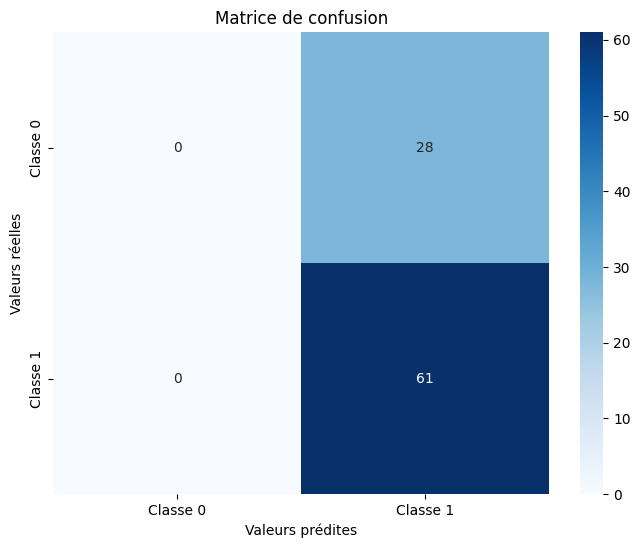

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

In [33]:


# Calcul de la précision
precision = precision_score(Y_test, Y_pred)

# Calcul de la sensibilité (recall)
recall = recall_score(Y_test, Y_pred)

# Calcul du score F1
f1 = f1_score(Y_test, Y_pred)

print("Précision (Precision):", precision)
print("Sensibilité (Recall):", recall)
print("Score F1 (F1 score):", f1)

Précision (Precision): 0.6853932584269663
Sensibilité (Recall): 1.0
Score F1 (F1 score): 0.8133333333333332
